## Load the dataset
### https://www.kaggle.com/code/ekrembayar/rfm-analysis-online-retail-ii

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df1 = pd.read_excel('archive/online_retail_II.xlsx', sheet_name='Year 2009-2010')
df2 = pd.read_excel('archive/online_retail_II.xlsx', sheet_name='Year 2010-2011')

merged_df = pd.concat([df1, df2], ignore_index=True)

merged_df.head(15)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


## Features

>Invoice: her işlem için eşi olmayan bir numara. Bir işlemi ifade etmek için kullanılır. \
>StockCode: Ürünün özel kodu. \
>Description: Ürün açıklaması. \
>Quantity: Satılan ürün miktarı. \
>InvoiceDate: İşlemin yapıldığı tarih.  \
>Price: Birim başına fiyat. \
>Customer ID: Müşteriye özgü kod.  \
>Country: İşlemin yapıldığı ülke. 

Stok kodu, ürün bazında analiz yapmak için çok önemlidir. Hangi ürünün popüler olduğu, stok seviyelerinin durumunu stok koduna göre bulabiliriz. 
Quantity, hangi ürüne ne kadar talep olduğunu anlamak için kullanılabilir. 
InvoiceDate, müşterinin zamana bağlı alışveriş alışkanlıkları, mevsimsel hatta güne özgü satış dinamiklerini analiz etmek için kullanılır. 
Price, gelir hesaplama, fiyat tahmin etmede kullanilabilir. 
Country, müşteri alışkanlıklarını anlamada ülke bazlı analizler yapmamızı sağlar. 

Satış tahmini için en önemli featurelar, quantity, invoicedate, stockcode ve price çünkü satışın geliri ve stok yönetimi, ürünün fiyatına, satış miktarına ve tarihe göre farklılık gösterebilir. 

### Check Data Types

In [22]:
print(type(merged_df['StockCode'][0])) # str
print(type(merged_df['Customer ID'][0])) # float

# change to datetime
merged_df['InvoiceDate'] = pd.to_datetime(merged_df['InvoiceDate']) 
#merged_df['Customer ID'] = merged_df['Customer ID'].astype(str)
merged_df['StockCode'] = merged_df['StockCode'].astype(str)

<class 'int'>
<class 'numpy.float64'>


### Data Exploration

In [31]:
print("Total entry in data: ", len(merged_df))

unique_invoices = merged_df['Invoice'].nunique()
print(f'There are {unique_invoices} unique invoice numbers.')

un = merged_df['StockCode'].nunique()
print(f'There are {un} unique stock code numbers.')

correlation = merged_df['Quantity'].corr(merged_df['Price'])
print(f'Correlation between Quantity and Price: {correlation}')

Total entry in data:  1067365
There are 53622 unique invoice numbers.
There are 5305 unique stock code numbers.
Correlation between Quantity and Price: -0.0019200284013951388


### Handle missing data

In [24]:
print(merged_df.isnull().sum())

# we observed there is missing values in Description and Customer ID

merged_df['Customer ID'].fillna(0, inplace=True) # Unknown Customer IDs to 0 

# We can fill descriptions with same stock code descriptions. 
# Lets check if stock code and descriptions are one to one. 
unique_descriptions = merged_df.groupby('StockCode')['Description'].nunique()

print("\nUnique descriptions per StockCode:")
print(unique_descriptions.sort_values(ascending=False))

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

Unique descriptions per StockCode:
StockCode
20713     9
22423     7
23084     7
21181     7
22734     7
         ..
84250H    0
79070B    0
84248F    0
84248E    0
84585L    0
Name: Description, Length: 5305, dtype: int64


In [25]:
# They are not one to one mapped. So get the most common description.
# Create a mapping from StockCode to the most common Description
# Get the most frequent value.

description_mapping = merged_df.groupby('StockCode')['Description'].agg(pd.Series.mode).to_dict()

# Fill missing descriptions
def fill_description(row):
    if pd.isna(row['Description']) and row['StockCode'] in description_mapping:
        if isinstance(description_mapping[row['StockCode']], pd.Series):
            return description_mapping[row['StockCode']][0]
        else:
            return description_mapping[row['StockCode']]
    else:
        return row['Description']

merged_df['Description'] = merged_df.apply(fill_description, axis=1)

print(merged_df.isnull().sum())

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64


#### No missing values!

### Outlier Handling

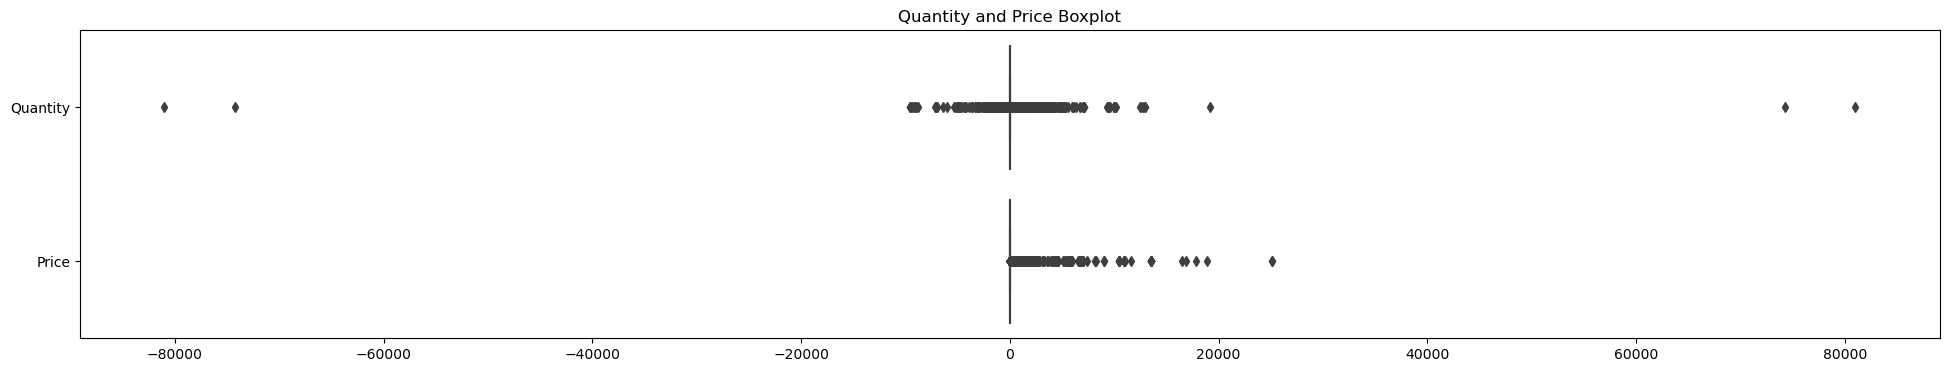

In [29]:
plt.figure(figsize=(24, 4))
sns.boxplot(data=merged_df[['Quantity', 'Price']], orient="h")
plt.title('Quantity and Price Boxplot')
plt.show()

In [34]:
negative_quantities = merged_df[merged_df['Quantity'] < 0]['Quantity'].count()
negative_prices = merged_df[merged_df['Price'] < 0]['Price'].count()

print("Price Outliers: ")
print("Count of negative prices:", negative_prices)

# Price can not be negative
# Filter out rows with negative prices and above 30000 
outliers = merged_df[(merged_df['Price'] < 0) | (merged_df['Price'] > 30000)]
count_outliers = outliers.shape[0]

merged_df = merged_df[(merged_df['Price'] >= 0) & (merged_df['Price'] <= 30000)]

print("Count of removed price outliers:", count_outliers)
print("\nQuantity Outliers: ")
print("Count of negative quantities:", negative_quantities)
# There is lots of negative quantity. I assume this represents something, like returns or cancellations. 
# We will not take this as errors.
# Filter above 40000 and below -40000 based on boxplot. 
outliers = merged_df[(merged_df['Quantity'] > 40000) | (merged_df['Quantity'] < -40000)]
count_outliers = outliers.shape[0]  # Count of outliers

# Remove outliers
df_clean = merged_df[(merged_df['Quantity'] <= 40000) & (merged_df['Quantity'] >= -40000)]

print("Count of removed quantity outliers:", count_outliers)

Price Outliers: 
Count of negative prices: 0
Count of removed price outliers: 0

Quantity Outliers: 
Count of negative quantities: 22949
Count of removed quantity outliers: 4


### Feature Engineering

In [36]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

df_sales = df_clean.copy() 

# Breaking down the InvoiceDate into multiple features such as year, month, day, and hour
df_sales['Year'] = df_sales['InvoiceDate'].dt.year
df_sales['Month'] = df_sales['InvoiceDate'].dt.month
df_sales['WeekOfYear'] = df_sales['InvoiceDate'].dt.isocalendar().week
df_sales['DayOfMonth'] = df_sales['InvoiceDate'].dt.day
df_sales['DayOfWeek'] = df_sales['InvoiceDate'].dt.dayofweek
df_sales['Hour'] = df_sales['InvoiceDate'].dt.hour

# Calculate total spend: Quantity * Price 
df_sales['TotalSpend'] = df_sales['Quantity'] * df_sales['Price']

df_sales.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Year,Month,WeekOfYear,DayOfMonth,DayOfWeek,Hour,TotalSpend
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009,12,49,1,1,7,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,49,1,1,7,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,49,1,1,7,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009,12,49,1,1,7,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009,12,49,1,1,7,30.0


## Sales Prediction

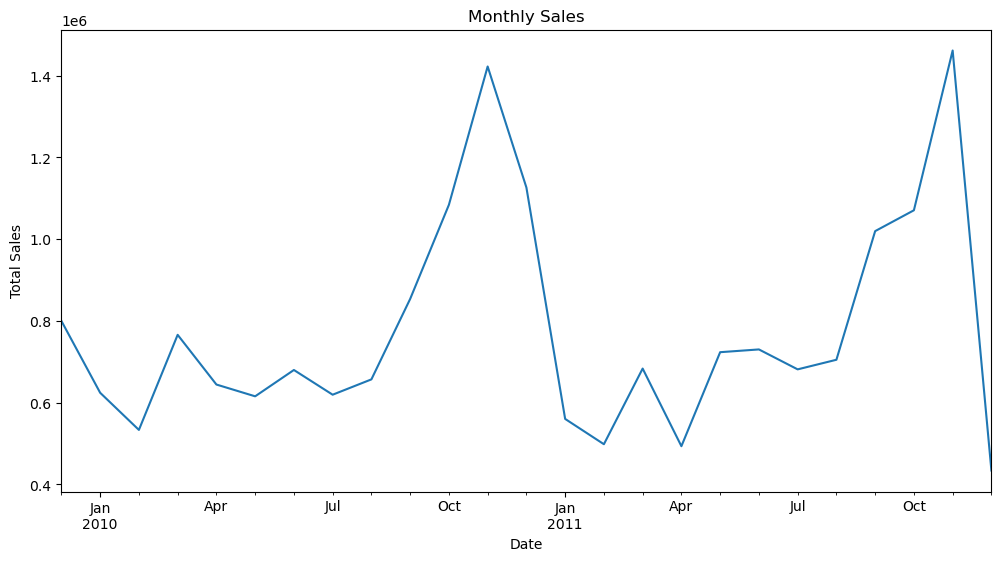

In [37]:
df_sales.set_index('InvoiceDate', inplace=True)

# Sales data monthly
monthly_sales = df_sales['TotalSpend'].resample('M').sum()

plt.figure(figsize=(12, 6))
monthly_sales.plot(title='Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

### We can see seasonality from monthly graph, increased total spend in October and the general pattern look very similar between two years.

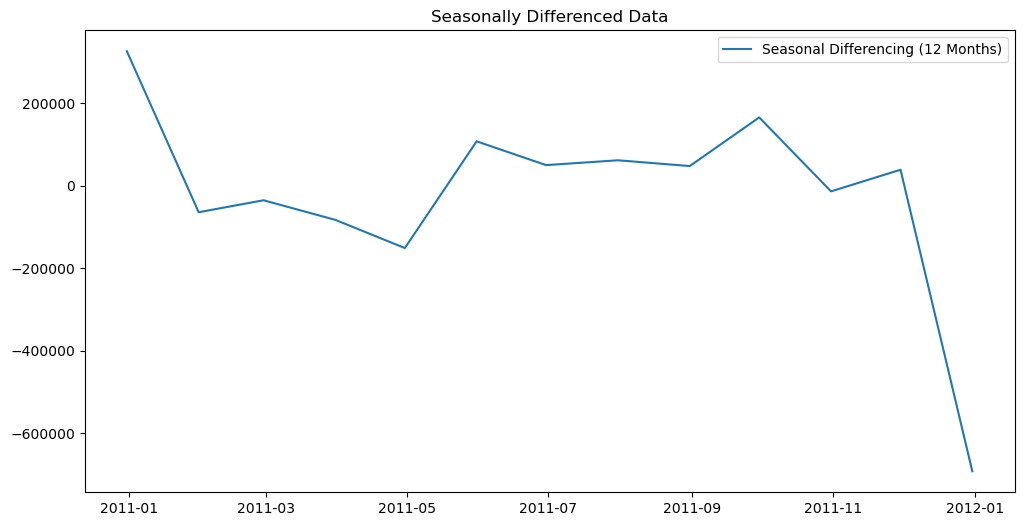

In [38]:
# Winter peaks suggest an annual seasonality
seasonal_diff = monthly_sales.diff(12).dropna()

plt.figure(figsize=(12, 6))
plt.plot(seasonal_diff, label='Seasonal Differencing (12 Months)')
plt.title('Seasonally Differenced Data')
plt.legend()
plt.show()

- Almost stationary when seasonally differenced, suggest there is only seasonal trend. (Not consider start date and ending)

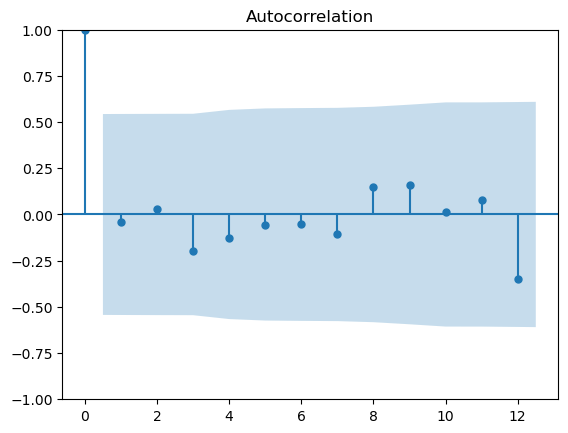

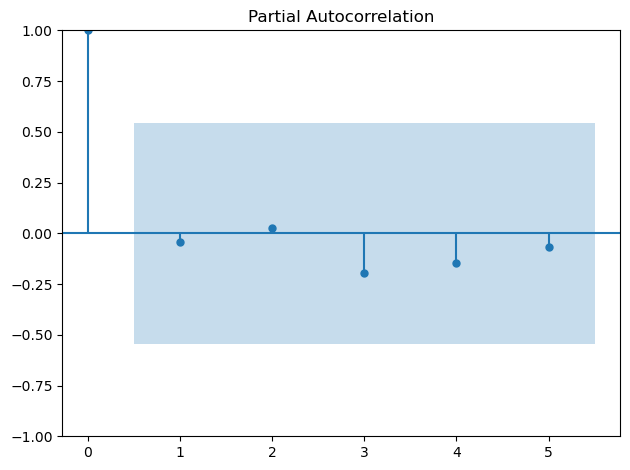

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#ACF and PACF

plot_acf(seasonal_diff, lags=12)
plot_pacf(seasonal_diff, lags=5)

plt.tight_layout()
plt.show()

- Autocorrelation graphs support seasonal trend claim.

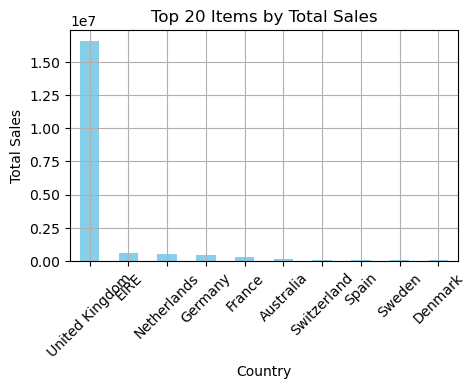

In [40]:
# Country Total Spends
stock_sales = df_sales.groupby('Country')['TotalSpend'].sum().sort_values(ascending=False)
top_stock_sales = stock_sales.head(10)

plt.figure(figsize=(5, 3))
top_stock_sales.plot(kind='bar', color='skyblue')
plt.title('Top 20 Items by Total Sales')
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

-  Most of the sales already from UK, not indicative

### Train

We will do monthly sales prediction by estimating quantity. 

In [41]:
# There are lots of product types (>5000) so we are going to group similar products tends to show same trend monthly.

df_monthly = df_clean.copy() 
df_monthly["MonthNum"] = df_monthly['InvoiceDate'].dt.month

# Train Test split
df_monthly_train = df_monthly[df_monthly['InvoiceDate'] < '2010-12-01']
df_monthly_test = df_monthly[(df_monthly['InvoiceDate'] >= '2010-12-01') & (df_monthly['InvoiceDate'] < '2011-12-01')]

In [42]:
# Monthly quantities
df_monthly_qt = df_monthly_train.groupby(["StockCode", "MonthNum"])["Quantity"].sum().reset_index()

# Creating a DataFrame with all combinations of 'StockCode' and 'MonthNum' from 1 to 12
all_stock_codes = df_monthly_qt['StockCode'].unique()
all_month_nums = range(1, 13)  # month numbers from 1 to 13
all_combinations = pd.MultiIndex.from_product([all_stock_codes, all_month_nums], names=['StockCode', 'MonthNum'])
df_all_combinations = pd.DataFrame(index=all_combinations).reset_index()

# Merging the original data with the full combination DataFrame
df_full_data = pd.merge(df_all_combinations, df_monthly_qt, on=['StockCode', 'MonthNum'], how='left')

# Filling NaN values with 0 for the 'Quantity'
df_full_data['Quantity'] = df_full_data['Quantity'].fillna(0)

# Sort by StockCode and MonthNum
df_full_data = df_full_data.sort_values(by=["StockCode", "MonthNum"])
df_full_data.Quantity = df_full_data.Quantity.astype(int)
df = df_full_data
df

,StockCode,MonthNum,Quantity
0,10002,1,291
1,10002,2,257
2,10002,3,642
3,10002,4,932
4,10002,5,464
...,...,...,...
55447,m,8,0
55448,m,9,0
55449,m,10,0
55450,m,11,0


## Product Trend Categorization

- Use cosine similarity to select similar products that show similar pattern. (high sales in Summer etc.)
- Hierarchical Clustering for finding optimal number of groups

We wanted to do this clustering because we think looking different products as a whole discard the sales pattern of indiviudal products. One product selling higher in summer cancel out the product selling low in summer for example. 

In [43]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform

In [44]:
# StockCode vs Month dataframe
df_pivot = df.pivot(index='StockCode', columns='MonthNum', values='Quantity')
# Handle 0 vectors
df_pivot[(df_pivot**2).sum(axis=1) == 0] = 0.5

# Compute the cosine distances between embeddings (rows)
distance_matrix = pdist(df_pivot, metric='cosine')

# Perform hierarchical clustering
linkage_matrix = linkage(distance_matrix, method='average')

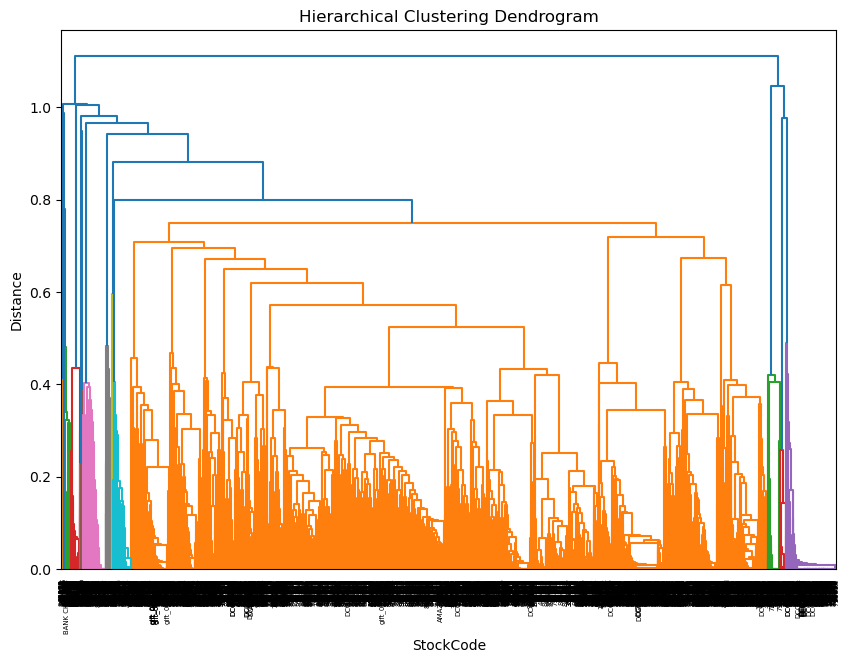

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=df_pivot.index)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('StockCode')
plt.ylabel('Distance')
plt.show()

In [46]:
# t threshold for optimal number of clusters, based on dendrogram
t = 0.99 # we want small cluster number
clusters = fcluster(linkage_matrix, t=t, criterion='distance')

# Map cluster numbers back to StockCodes
cluster_map = pd.Series(clusters, index=df_pivot.index)
print("Cluster memberships:")
print(cluster_map)
cluster_map.nunique()

Cluster memberships:
StockCode
10002           3
10002R          3
10080           3
10109           5
10120           3
               ..
gift_0001_60    3
gift_0001_70    3
gift_0001_80    3
gift_0001_90    3
m               3
Length: 4621, dtype: int32


5

### Products clustered in 5 groups based on their similar trends.

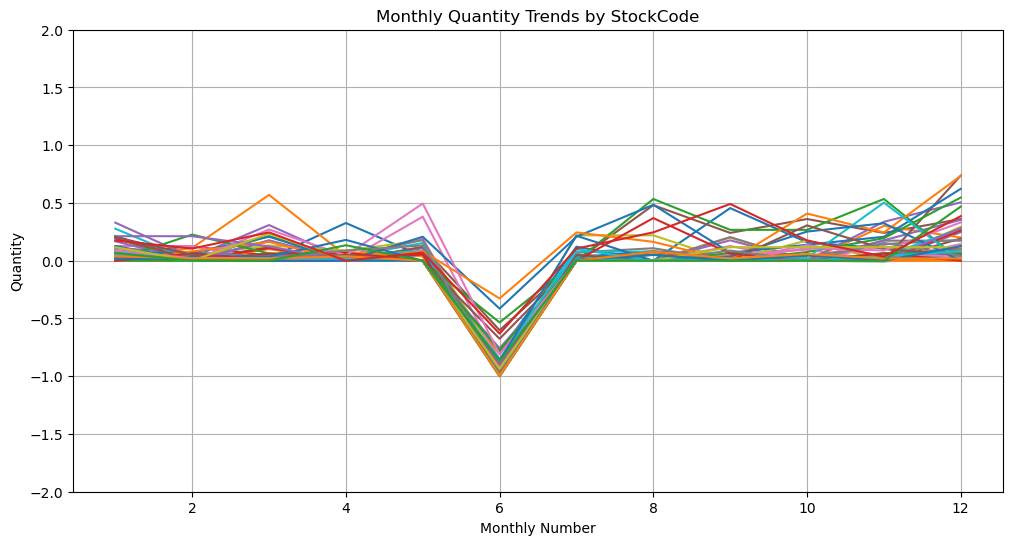

In [47]:
# Visual inspection of Clusters
grp_num = 2 
a_group = df_pivot.loc[cluster_map[cluster_map==grp_num].index]
plt.figure(figsize=(12, 6))

for index, row in a_group.iterrows():
    # Normalize the row
    row_len = np.linalg.norm(row)  
    if row_len != 0:  
        row = row / row_len 
    plt.plot(a_group.columns, row, label=index)

plt.title('Monthly Quantity Trends by StockCode')
plt.xlabel('Monthly Number')
plt.ylabel('Quantity')
plt.ylim(-2, 2)
plt.grid(True)
plt.show()

#### Store average Price per product for Total Spend calculation later

In [48]:
weighted_means_train = df_monthly_train[df_monthly_train.Quantity>0].groupby(["StockCode", "MonthNum"]).apply(
    lambda x: np.average(x['Price'], weights=x['Quantity']) if np.sum(x['Quantity']) > 0 else 0)

weighted_means_test = df_monthly_test[df_monthly_test.Quantity>0].groupby(["StockCode", "MonthNum"]).apply(
    lambda x: np.average(x['Price'], weights=x['Quantity']) if np.sum(x['Quantity']) > 0 else 0)

weighted_means_train

StockCode     MonthNum
10002         1           0.855567
              2           0.856304
              3           0.769377
              4           0.745345
              5           0.790096
                            ...   
gift_0001_90  1           0.000000
              8           0.000000
m             2           2.975000
              4           4.000000
              6           2.550000
Length: 33211, dtype: float64

In [49]:
# Store normalization for denormalize at the end. 
norm_dict = {}

# Euclidean norm
for index, row in df_pivot.iterrows():
    norm = np.linalg.norm(row) 
    norm_dict[index] = norm

df_normalized = df_pivot.apply(lambda row: row / norm_dict[row.name] if row.name in norm_dict else row, axis=1)
# add the clustering class nums
df_normalized['StockCodeCategory'] = df_normalized.index.map(cluster_map)

In [52]:
df_normalized

MonthNum,1,2,3,4,5,6,7,8,9,10,11,12,StockCodeCategory
StockCode,,,,,,,,,,,,,
10002,0.136090,0.120190,0.300240,0.435863,0.216996,0.211852,0.239444,0.268439,0.113175,0.489176,0.450828,0.101015,3
10002R,0.316228,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.948683,3
10080,0.000000,0.000000,0.000000,0.000000,0.996683,0.000000,0.011074,0.000000,0.066446,0.000000,0.011074,0.044297,3
10109,0.000000,-0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.707107,5
10120,0.003556,0.000556,0.004223,0.006668,-0.999809,0.003334,0.000333,0.000000,0.001000,0.007891,0.008335,0.012781,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
gift_0001_60,0.287348,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.957826,0.000000,0.000000,0.000000,0.000000,3
gift_0001_70,0.195180,0.000000,0.000000,0.000000,0.000000,0.097590,0.000000,0.975900,0.000000,0.000000,0.000000,0.000000,3
gift_0001_80,-0.095346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.953463,0.000000,0.000000,0.000000,0.286039,3


In [50]:
# Create dummy for clustering group
df_melted = df_normalized.reset_index().melt(id_vars=['StockCode', 'StockCodeCategory'], var_name='MonthNum', value_name='target') # reshape
df_train_final = pd.get_dummies(df_melted, columns=['MonthNum'], prefix='MonthNum')
df_train_final = pd.get_dummies(df_train_final, columns=['StockCodeCategory'], prefix='StockCodeCategory')
df_train_final

,StockCode,target,MonthNum_1,MonthNum_2,MonthNum_3,MonthNum_4,MonthNum_5,MonthNum_6,MonthNum_7,MonthNum_8,MonthNum_9,MonthNum_10,MonthNum_11,MonthNum_12,StockCodeCategory_1,StockCodeCategory_2,StockCodeCategory_3,StockCodeCategory_4,StockCodeCategory_5
0,10002,0.136090,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
1,10002R,0.316228,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2,10080,0.000000,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
3,10109,0.000000,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,10120,0.003556,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55447,gift_0001_60,0.000000,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False
55448,gift_0001_70,0.000000,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False
55449,gift_0001_80,0.286039,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False
55450,gift_0001_90,0.000000,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False


### Test Set

In [53]:
# Prepare Test set similar to Train set
df_test = df_monthly_test.groupby(["StockCode", "MonthNum"])["Quantity"].sum()
df_test = pd.DataFrame(df_test.reset_index())

# map stock code to cluster it belong
df_test['StockCodeCategory'] = df_test.StockCode.map(cluster_map)

# There are unseen products, can't estimate them, loose 10% of test data
df_test = df_test[~df_test["StockCodeCategory"].isna()]
df_test['StockCodeCategory'] = df_test['StockCodeCategory'].astype(int)
df_test = pd.get_dummies(df_test, columns=['MonthNum'], prefix='MonthNum')
df_test = pd.get_dummies(df_test, columns=['StockCodeCategory'], prefix='StockCodeCategory')

# handle missing cols in df_test
missing_columns = set(df_train_final.columns) - set(df_test.columns) - set(["target"])
for col in missing_columns:
    df_test[col] = False
    
first_list = df_test.columns[:2]  # StockCode, Quantity
second_list = df_test.columns[2:14]  # MonthNum_1, MonthNum_2, ..., MonthNum_12
third_list = sorted(df_test.columns[14:], key=lambda x: int(x.split("_")[1]))  # Sorted StockCodeCategory columns
combined_columns = list(first_list) + list(second_list) + list(third_list)

# reorder test cols
df_test = df_test[combined_columns]

# Add normalization value to df for later denormalization of the predicted quantity.
df_test["TrainEucDist"] = df_test["StockCode"].map(norm_dict)
df_test

,StockCode,Quantity,MonthNum_1,MonthNum_2,MonthNum_3,MonthNum_4,MonthNum_5,MonthNum_6,MonthNum_7,MonthNum_8,MonthNum_9,MonthNum_10,MonthNum_11,MonthNum_12,StockCodeCategory_1,StockCodeCategory_2,StockCodeCategory_3,StockCodeCategory_4,StockCodeCategory_5,TrainEucDist
0,10002,340,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,2138.287866
1,10002,52,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,2138.287866
2,10002,208,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,2138.287866
3,10002,186,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,2138.287866
4,10002,411,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,2138.287866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32191,gift_0001_40,1,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,11.445523
32192,gift_0001_50,1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,10.535654
32193,gift_0001_50,2,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,10.535654
32194,gift_0001_50,1,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,10.535654


# Inference:
>     in a given month, for a given product:
>>     estimate the total sold quantity

# Random Forest Regressor
> It can capture nonlinear relations. We have lots of categorical variable, it handles them efficiently.
It also provide insights into which features are most important for making predictions. 

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Do not include quantity and stock code to data
features = df_train_final.columns[2:-1]

X_train = df_train_final[features]
y_train = df_train_final['target'] #normalized quantity
X_test = df_test[features]
y_test = df_test["Quantity"]

random_forest = RandomForestRegressor(n_estimators=150, random_state=0)
random_forest.fit(X_train, y_train)

# Denormalize the predicted quantity result. 
y_pred = random_forest.predict(X_test) * df_test["TrainEucDist"]
df_test["Preds"] = y_pred

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

Mean Squared Error: 105534.5939949994
R-squared: 0.34690293244948145


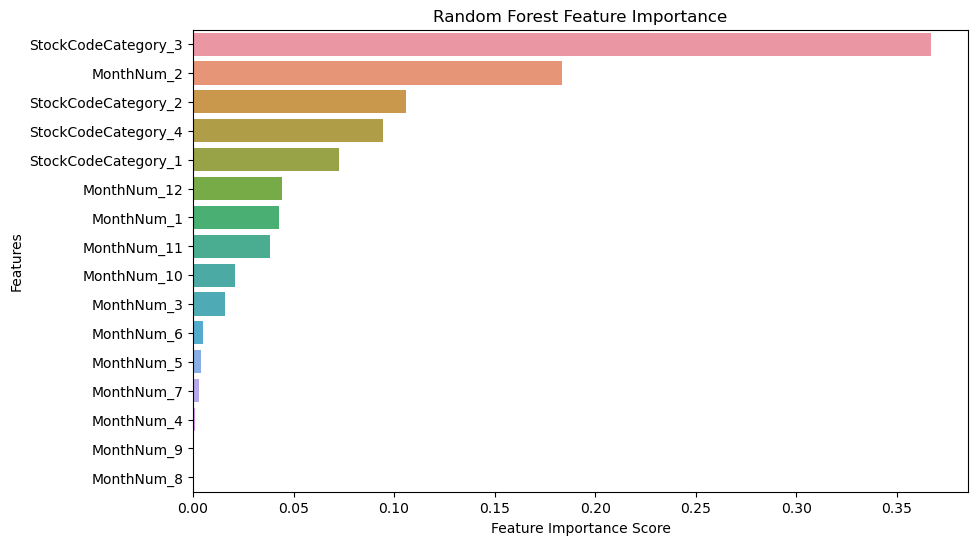

In [56]:
# Feature Importance
importances = random_forest.feature_importances_
feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.show()

### This graphs show us which feature (which product or which month) effects the total sold quantity more.
> If product types also show high importance, it suggests that the type of product significantly affects sales predictions.
> An important month suggest there might be spikes in this month, business decisions could focus more on this month. For example, in retail, marketing campaigns or stock adjustments might be prioritized for february.

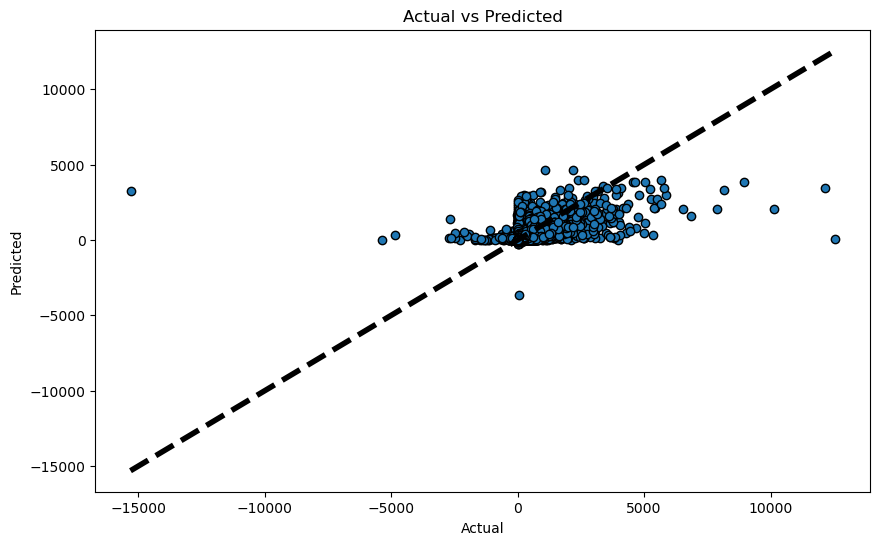

In [57]:
# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.title('Actual vs Predicted')
plt.show()

In [58]:
# Melt the categorical variables to normal for ease.
df_test_summary = pd.melt(df_test, 
                    id_vars=['StockCode', 'Quantity', 'TrainEucDist', "Preds"], 
                    value_vars=[col for col in df_test.columns if 'MonthNum_' in col], 
                    var_name='MonthNum', 
                    value_name='MonthValue')
df_test_summary['MonthNum'] = df_test_summary['MonthNum'].str.extract('(\d+)').astype(int)
df_test_summary = df_test_summary[df_test_summary['MonthValue']]
df_test_summary = df_test_summary.drop(columns=['MonthValue'])
df_test_summary

,StockCode,Quantity,TrainEucDist,Preds,MonthNum
0,10002,340,2138.287866,356.081196,1
33,10125,213,286.262118,47.670175,1
44,10133,180,315.165036,52.483272,1
56,10135,613,964.710838,160.649740,1
68,11001,33,1160.818246,193.306784,1
...,...,...,...,...,...
346647,POST,312,1567.577430,370.597442,12
346656,S,-4,16.822604,4.017632,12
346675,gift_0001_40,1,11.445523,2.705883,12
346678,gift_0001_50,1,10.535654,2.490777,12


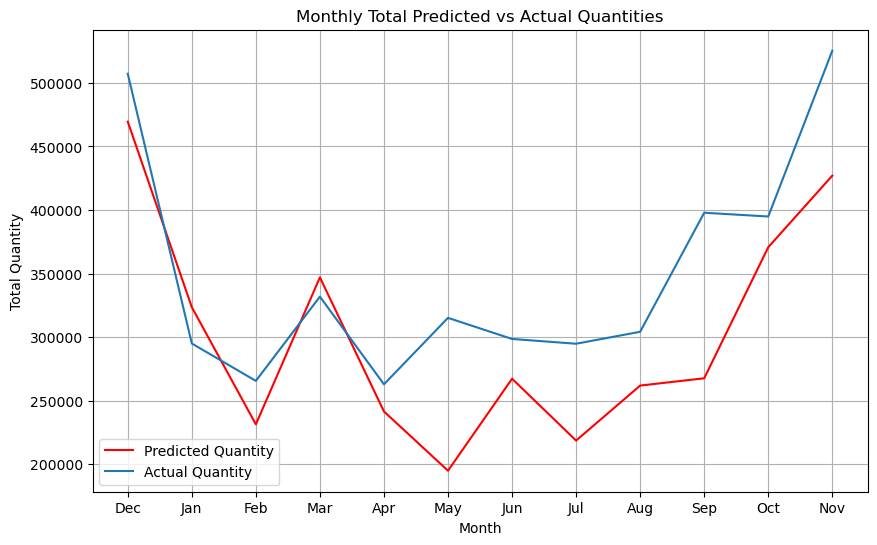

In [59]:
monthly_total_pred_qtys = df_test_summary.groupby(["MonthNum"])["Preds"].sum()
monthly_total_gt_qtys = df_test_summary.groupby(["MonthNum"])["Quantity"].sum()

# start from dec, as we train from 2009 dec to 2010 nov (included)
my_range = [12,]
my_range.extend([i for i in range(1, 12)])

monthly_total_pred_qtys = monthly_total_pred_qtys.reindex(my_range)
monthly_total_gt_qtys = monthly_total_gt_qtys.reindex(my_range)

plt.figure(figsize=(10, 6))
plt.plot(list(range(1,13)), monthly_total_pred_qtys, color='r', label='Predicted Quantity')
plt.plot(list(range(1,13)), monthly_total_gt_qtys, label='Actual Quantity')

plt.xticks(list(range(1,13)), ['Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'])


plt.title('Monthly Total Predicted vs Actual Quantities')
plt.xlabel('Month')
plt.ylabel('Total Quantity')
plt.legend()
plt.grid(True)

plt.show()

In [60]:
# Add Total Spend column for monatary sales value.
# Multiply each products average price * quantity
weighted_means_test_df = weighted_means_test.reset_index()
weighted_means_test_df.columns = ['StockCode', 'MonthNum', 'WeightedMeanPriceTest']

weighted_means_train_df = weighted_means_train.reset_index()
weighted_means_train_df.columns = ['StockCode', 'MonthNum', 'WeightedMeanPriceTrain']

all_months_test = pd.MultiIndex.from_product([weighted_means_test_df['StockCode'].unique(), range(1, 13)], names=['StockCode', 'MonthNum'])
all_months_train = pd.MultiIndex.from_product([weighted_means_train_df['StockCode'].unique(), range(1, 13)], names=['StockCode', 'MonthNum'])

weighted_means_test_df = weighted_means_test_df.set_index(['StockCode', 'MonthNum']).reindex(all_months_test)
weighted_means_train_df = weighted_means_train_df.set_index(['StockCode', 'MonthNum']).reindex(all_months_train)

# Fill missing values with the mean of the corresponding StockCode
weighted_means_test_df['WeightedMeanPriceTest'] = weighted_means_test_df.groupby('StockCode')['WeightedMeanPriceTest'].transform(lambda x: x.fillna(x.mean()))
weighted_means_train_df['WeightedMeanPriceTrain'] = weighted_means_train_df.groupby('StockCode')['WeightedMeanPriceTrain'].transform(lambda x: x.fillna(x.mean()))

weighted_means_test_df = weighted_means_test_df.reset_index()
weighted_means_train_df = weighted_means_train_df.reset_index()

# add weighted_means_test_df and weighted_means_train_df
df_test_summary_final = pd.merge(df_test_summary, weighted_means_test_df, on=['StockCode', 'MonthNum'], how='left')
df_test_summary_final = pd.merge(df_test_summary_final, weighted_means_train_df, on=['StockCode', 'MonthNum'], how='left')

# price * quantity
df_test_summary_final['TotalSpendReal'] = df_test_summary_final['Quantity'] * df_test_summary_final['WeightedMeanPriceTest']
df_test_summary_final['TotalSpendPred'] = df_test_summary_final['Preds'] * df_test_summary_final['WeightedMeanPriceTrain']

df_test_summary_final

,StockCode,Quantity,TrainEucDist,Preds,MonthNum,WeightedMeanPriceTest,WeightedMeanPriceTrain,TotalSpendReal,TotalSpendPred
0,10002,340,2138.287866,356.081196,1,0.856971,0.855567,291.370000,304.651325
1,10125,213,286.262118,47.670175,1,0.514789,1.660000,109.650000,79.132491
2,10133,180,315.165036,52.483272,1,0.632444,0.734630,113.840000,38.555766
3,10135,613,964.710838,160.649740,1,0.795073,1.250000,487.380000,200.812175
4,11001,33,1160.818246,193.306784,1,1.740606,1.690000,57.440000,326.688464
...,...,...,...,...,...,...,...,...,...
28885,POST,312,1567.577430,370.597442,12,19.952830,23.399600,6225.283019,8671.831893
28886,S,-4,16.822604,4.017632,12,31.525000,73.800000,-126.100000,296.501266
28887,gift_0001_40,1,11.445523,2.705883,12,34.040000,12.296667,34.040000,33.273345
28888,gift_0001_50,1,10.535654,2.490777,12,42.550000,43.480000,42.550000,108.298998


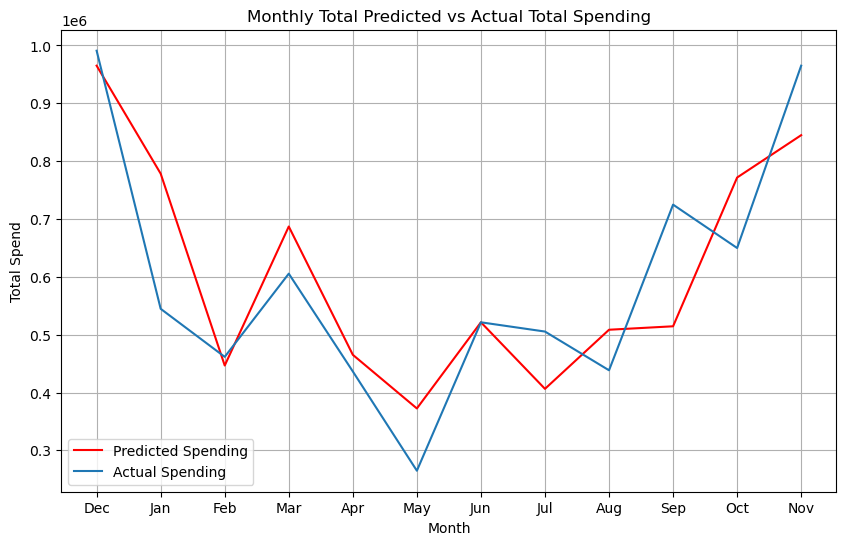

In [61]:
monthly_total_pred = df_test_summary_final.groupby(["MonthNum"])["TotalSpendPred"].sum()
monthly_total_gt = df_test_summary_final.groupby(["MonthNum"])["TotalSpendReal"].sum()

my_range = [12,]
my_range.extend([i for i in range(1, 12)])

monthly_total_pred = monthly_total_pred.reindex(my_range)
monthly_total_gt = monthly_total_gt.reindex(my_range)

plt.figure(figsize=(10, 6))
plt.plot([i for i in range(1,13)], monthly_total_pred, color='r', label='Predicted Spending')
plt.plot([i for i in range(1,13)], monthly_total_gt, label='Actual Spending')
plt.title('Monthly Total Predicted vs Actual Total Spending')
plt.xticks(list(range(1,13)), ['Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'])
plt.xlabel('Month')
plt.ylabel('Total Spend')
plt.legend()
plt.grid(True)

plt.show()